In [1]:
from __future__ import print_function
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import glob
from scipy import ndimage, misc
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

import random
import itertools

import wikipediaapi

In [2]:
wiki_wiki = wikipediaapi.Wikipedia('en')
page_py = wiki_wiki.page('COVID-19_misinformation')

#page_py = wiki_wiki.page('Python_(programming_language)')
print("Page - Exists: %s" % page_py.exists())
print("Page - Summary: %s" % page_py.summary[0:60])

Page - Exists: True
Page - Summary: The COVID-19 pandemic has resulted in misinformation and con


In [4]:
lst_misinfo=[]
i=0
for s in page_py.sections:
    #print(s.title)
    if i<7:
        for s2 in s.sections:
            #print(s2.title)
            lst_misinfo.append(s2.title)
    i=i+1
print(lst_misinfo)

['Wuhan lab leak story', 'Chinese espionage involving Canadian lab', 'United States biological weapon', 'Jewish origin', 'Anti-Muslim', 'Population-control scheme', '5G mobile phone networks', 'American scientist selling virus to China', 'Meteor origin', 'Chinese under-reporting during early 2020', 'Misleading Johns Hopkins News-Letter article', 'Allegations of inflated death counts', 'Alleged leak of death toll', 'Mass cremation in Wuhan', 'Misinformation against Taiwan', 'Misrepresented World Population Project map', 'Nurse whistleblower', 'Decline in cellphone subscriptions', 'Casedemic', 'California herd immunity in 2019', 'Patient Zero', 'Resistance/susceptibility based on ethnicity', 'Bat soup consumption', 'Large gatherings', 'Lifetime of the virus', 'Mosquitoes', 'Objects', "Cruise ships' safety from infection", 'Breastfeeding infants', 'Efficacy of hand sanitizer, "antibacterial" soaps', 'Public use of face masks', 'Alcohol', 'Warm or hot drinks', 'Vegetarian immunity', 'Relig

In [8]:
# add separation:
lst_misinfo2=[]
for el in lst_misinfo:
    if len(el)<19:
        lst_misinfo2.append(el)
    else:
        vec=el.split(' ')
        if len(vec)==1:
            el2=el[0:15]+'\n'+el[15:]
            lst_misinfo2.append(el2)
        elif len(vec)==2:
            el2=vec[0]+'\n'+vec[1]
            lst_misinfo2.append(el2)
        elif len(vec)==3 and len(vec[0])>len(vec[2]):
            el2=el2=vec[0]+'\n'+vec[1]+' '+vec[2]
            lst_misinfo2.append(el2)
        elif len(vec)==3 and len(vec[0])<len(vec[2]):
            el2=el2=vec[0]+' '+vec[1]+'\n'+vec[2]
            lst_misinfo2.append(el2)
            
        elif len(vec)==4:
            
            el2=el2=vec[0]+' '+vec[1]+'\n'+vec[2]+ ' '+ vec[3]
            lst_misinfo2.append(el2)
            
        else:
            el2=el[0:15]+'\n'+el[15:]
            lst_misinfo2.append(el2)
            
            
       
        
        #if len(el.split(' '))==2:
#            el2=el.split(' ')[0]+'\n'+el.split(' ')[1]
        #elif len(el.split(' '))==3:
        #    if len
            
        el2=el[0:15]+'\n'+el[15:]
        lst_misinfo2.append(el2)
        

#'\n'

In [9]:
from PIL import ImageFont, ImageDraw

#draw = ImageDraw.Draw(image)


#font = ImageFont.load("arial.pil")


def create_digit_img(digit, side):
    background =Image.new('RGB', (side, side), color = (255, 255, 255))
    font = ImageFont.truetype('Lato-Black.ttf', 12)
    #font = ImageFont.load("arial.pil")
    text=str(digit)
    draw = ImageDraw.Draw(background)
    #if digit>0:
    text_width, text_height = draw.textsize(text, font)
    position = ((side-text_width)/2,(side-text_height)/2)
    color=(0, 0, 0)
    draw.text(position, text, color, font=font)
    img=np.array(background)
    img=0.2989*img[:, :, 0]+0.5870*img[:, :, 1]+0.1140*img[:, :, 2]
    
    return img

def draw_lines(img, side, nn):
    
    ll=np.shape(img)[0]
    print(nn)
    for i in range(0, nn+1):
        print(i)
        if i in [0, 1, 2, 3, 4, 6]:
            img[side*i+1, 0:ll]=0
            img[0:ll, side*i+1]=0
        elif i==9:
            img[side*i-1, 0:ll]=0
            img[0:ll, side*i-1]=0
            
        img[side*i, 0:ll]=0
        img[0:ll, side*i]=0
    return img




    


In [10]:
# import random

nb=7 # number of black case
mx=25 #total number of cases



#'Ad Hominem', false dichotomy, Bandwagon fallacy, False cause

list_of_biais=lst_misinfo2

print(len(list_of_biais))
print(list_of_biais)
random.shuffle(list_of_biais)
print(list_of_biais)

a=np.linspace(0, mx-1, mx, dtype=int)
print(a)
print(type(a))
print(nb)
lst_b=random.sample(list(a), nb)
print(lst_b)

num_lst=mx-nb
lst_x=random.sample(list_of_biais, num_lst)

96
['Wuhan lab\nleak story', 'Wuhan lab leak \nstory', 'Chinese espiona\nge involving Canadian lab', 'Chinese espiona\nge involving Canadian lab', 'United States\nbiological weapon', 'United States b\niological weapon', 'Jewish origin', 'Anti-Muslim', 'Population-control\nscheme', 'Population-cont\nrol scheme', '5G mobile\nphone networks', '5G mobile phone\n networks', 'American scient\nist selling virus to China', 'American scient\nist selling virus to China', 'Meteor origin', 'Chinese under-r\neporting during early 2020', 'Chinese under-r\neporting during early 2020', 'Misleading John\ns Hopkins News-Letter article', 'Misleading John\ns Hopkins News-Letter article', 'Allegations of \ninflated death counts', 'Allegations of \ninflated death counts', 'Alleged leak of\n death toll', 'Alleged leak of\n death toll', 'Mass cremation\nin Wuhan', 'Mass cremation \nin Wuhan', 'Misinformation\nagainst Taiwan', 'Misinformation \nagainst Taiwan', 'Misrepresented \nWorld Population Project map', 

In [11]:

side=120 #Size of one cell
nn=5


backgr=np.ones((nn*side+1, nn*side+1))*255
#print(ll)
#put digits:
k=0

hh=5
kk=0
for i in range(0, nn):
    for j in range(0, nn):
        
        if kk in lst_b:
            backgr[i*side:(i+1)*side, j*side:(j+1)*side]=np.ones((np.shape(backgr[i*side:(i+1)*side, j*side:(j+1)*side])), dtype=int)*10
            print(i, j)
        else:
            #print(k)
            digit=lst_x[k]
            k=k+1
            img=create_digit_img(digit, side)
            backgr[i*side:(i+1)*side, j*side:(j+1)*side]=img
            
        #print(kk)
        
        kk=kk+1
#print(lst_x)
backgr=draw_lines(backgr, side, nn)

0 1
1 1
3 0
3 2
4 0
4 2
4 4
5
0
1
2
3
4
5


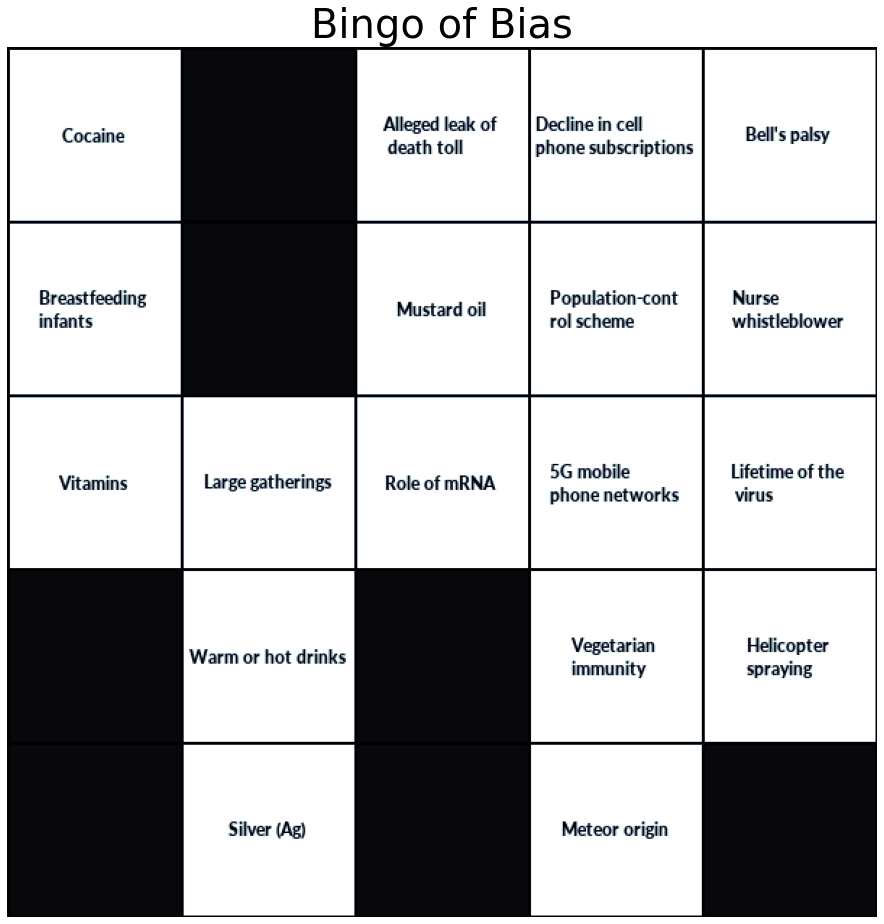

In [12]:

f = plt.figure(figsize=(16,16))
plt.imshow(backgr, cmap='bone')
plt.title('Bingo of Bias',fontsize=40)
plt.axis('off')
plt.savefig('img3.png')
plt.show()

In [30]:
type(backgr)

numpy.ndarray